In [401]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import kstest, jarque_bera, norm

In [355]:
data = pd.read_csv("BTC-USD.csv", usecols=["Open"])
y_data = data["Open"]
purple = '#2C0768'

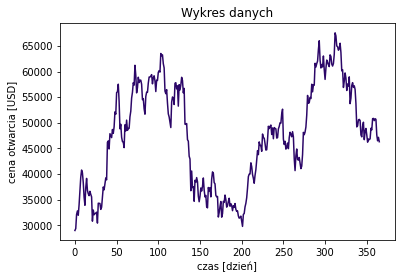

In [356]:
plt.plot(y_data, color=purple)
plt.title("Wykres danych")
plt.xlabel("czas [dzień]")
plt.ylabel("cena otwarcia [USD]")
plt.savefig("data_plot.png")
plt.show()

In [281]:
X_box_cox_trans = [np.log(x) for x in y_data]

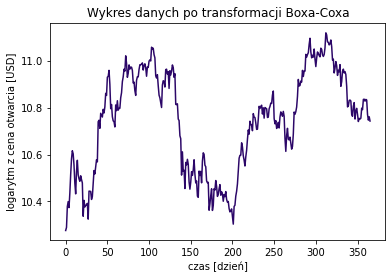

In [354]:
plt.plot(X_box_cox_trans, color=purple)
plt.title("Wykres danych po transformacji Boxa-Coxa")
plt.xlabel("czas [dzień]")
plt.ylabel("logarytm z cena otwarcia [USD]")
plt.savefig("wykres_box_cox_trans.png")

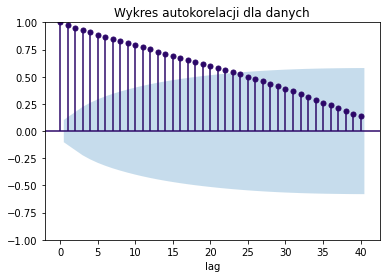

In [365]:
plot_acf(X_box_cox_trans, color=purple, vlines_kwargs={"colors": purple}, lags=40)
plt.title("Wykres autokorelacji dla danych")
plt.xlabel("lag")
plt.savefig("acf_dane.png")

In [283]:
# create a differenced series
def difference(dataset, interval=1):
    diff = []
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

In [366]:
X_diff_clear = difference(X_box_cox_trans, interval=1)
with open('data.txt', 'w') as f:
    for observation in X_diff_clear:
        f.write(str(observation))
        f.write('\n')

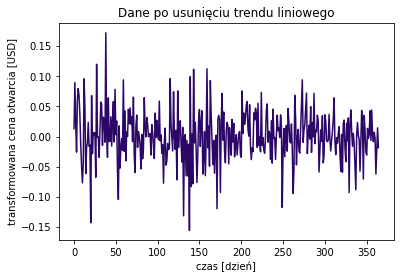

In [481]:
plt.plot(X_diff_clear, color=purple)
plt.title("Dane po usunięciu trendu liniowego")
plt.xlabel("czas [dzień]")
plt.ylabel("transformowana cena otwarcia [USD]")
plt.savefig("wykres_wyczyszczonych_danych.png")
plt.show()

In [368]:
print(np.mean(X_diff_clear))

0.0012830311654651611


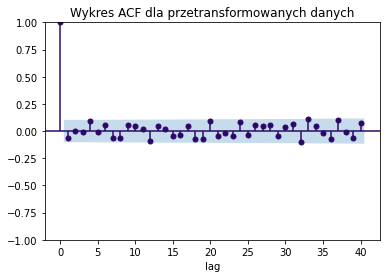

In [484]:
plot_acf(X_diff_clear, color=purple, vlines_kwargs={"colors": purple}, lags=40)
plt.title("Wykres ACF dla przetransformowanych danych")
plt.xlabel("lag")
plt.savefig("wykres_acf_dane.png")

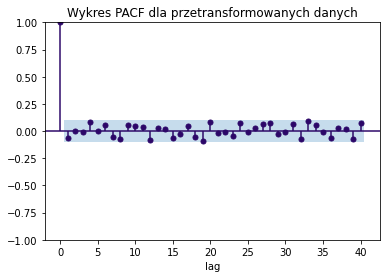

In [487]:
plot_pacf(X_diff_clear, color=purple, vlines_kwargs={"colors": purple}, lags=40, method="ywm")
plt.title("Wykres PACF dla przetransformowanych danych")
plt.xlabel("lag")
plt.savefig("wykres_pacf_dane.png")


In [275]:
def sine(t, amp, freq, phase, c):
    return amp*np.sin(freq*t + phase) + c

In [276]:
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   #assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy)*2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A*np.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    return [A, w, p, c]

In [386]:
residuals = []
with open('residuals.txt') as f:
    lines = f.readlines()
    for line in lines:
        residuals.append(float(line.strip()))

In [424]:
mu_residuals = np.mean(residuals)
sigma_residuals = np.var(residuals)
print(mu_residuals)
print(sigma_residuals)

-2.4047743448071926e-05
0.0016944593335152538


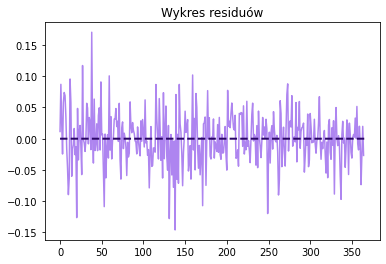

In [434]:
purple2 = "#AE85F0"
x_range = np.linspace(0, len(residuals), 10000)
plt.plot(residuals, color=purple2)
plt.plot(x_range, [mu_residuals for __ in range(len(x_range))], linestyle='--', linewidth=2, color=purple)
plt.title("Wykres residuów")
plt.savefig("residuals_plot.png")

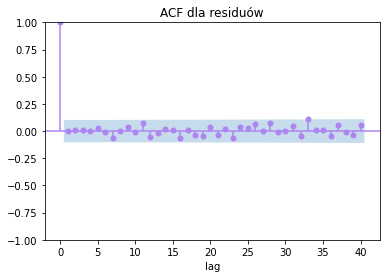

In [435]:
plot_acf(residuals, color=purple2, vlines_kwargs={"colors": purple2}, lags=40)
plt.title("ACF dla residuów")
plt.xlabel("lag")
plt.savefig("wykres_acf_residua.png")

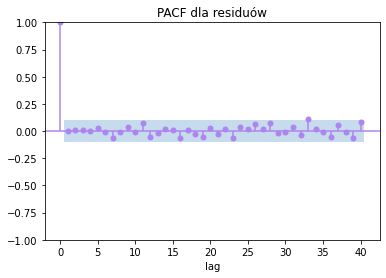

In [436]:
plot_pacf(residuals, color=purple2, vlines_kwargs={"colors": purple2}, lags=40, method="ywm")
plt.title("PACF dla residuów")
plt.xlabel("lag")
plt.savefig("wykres_pacf_residua.png")

In [404]:
print("Kolmogorov-Smirnov test p-value:", kstest(residuals, 'norm').pvalue)
print("Jarque-Bera test p-value:", jarque_bera(residuals).pvalue)

Kolmogorov-Smirnov test p-value: 3.3031814559733234e-69
Jarque-Bera test p-value: 2.5938893943866503e-06


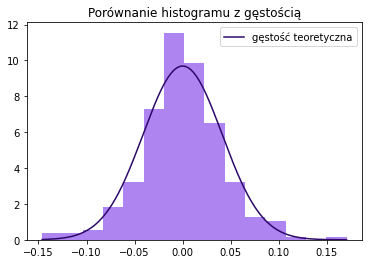

In [444]:
x_range = np.linspace(min(residuals), max(residuals), 1000)
ecdf = ECDF(residuals)
plt.hist(residuals, color=purple2, bins=15, density=True)
plt.plot(x_range, norm.pdf(x_range, loc=np.mean(residuals), scale=np.std(residuals)), color=purple, label="gęstość teoretyczna")
plt.legend()
plt.title("Porównanie histogramu z gęstością")
plt.savefig("hist_residuals.png")

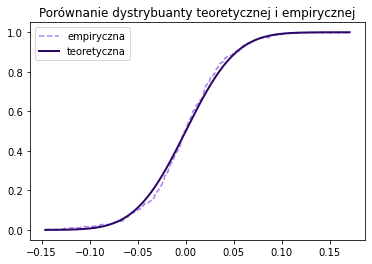

In [440]:
plt.plot(x_range, ecdf(x_range), label="empiryczna", linestyle="--", color=purple2)
plt.plot(x_range, norm.cdf(x_range, loc=np.mean(residuals), scale=np.std(residuals)), label="teoretyczna", color=purple, linewidth=2)
plt.title("Porównanie dystrybuanty teoretycznej i empirycznej")
plt.legend()
plt.savefig("dystr_residuals.png")

In [468]:
h_range = np.arange(0, 41)

theo_acf = []
with open('model_acf.txt') as f:
    lines = f.readlines()
    for line in lines:
        theo_acf.append(float(line.strip()))

sample_acf = []
with open('sample_acf.txt') as f:
    lines = f.readlines()
    for line in lines:
        sample_acf.append(float(line.strip()))

theo_pacf = []
with open('model_pacf.txt') as f:
    lines = f.readlines()
    for line in lines:
        theo_pacf.append(float(line.strip()))

sample_pacf = []
with open('sample_pacf.txt') as f:
    lines = f.readlines()
    for line in lines:
        sample_pacf.append(float(line.strip()))

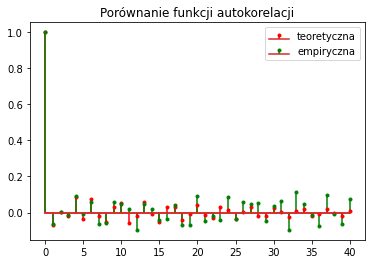

In [478]:
plt.stem(h_range, theo_acf, markerfmt="r.", label="teoretyczna", linefmt="r")
plt.stem(h_range, sample_acf, markerfmt="g.", label="empiryczna", linefmt="g")
plt.legend()
plt.title("Porównanie funkcji autokorelacji")
plt.savefig("acf_theo_emp.png")

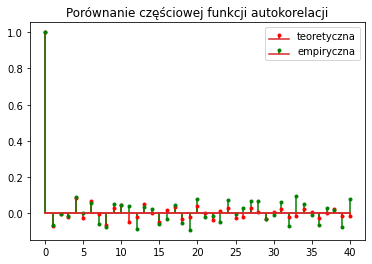

In [480]:
plt.stem(h_range, theo_pacf, markerfmt="r.", label="teoretyczna", linefmt="r")
plt.stem(h_range, sample_pacf, markerfmt="g.", label="empiryczna", linefmt="g")
plt.legend()
plt.title("Porównanie częściowej funkcji autokorelacji")
plt.savefig("pacf_theo_emp.png")